# Data loader
data in /dds/workspace/data_ja/

In [2]:
!ls /dds/work/workspace/data_ja/

CAT_1_9013.jpg	CAT_1_9024.jpg	RF-CAT1-v1.0.csv


### fonction de chargement d'image jpeg par morceau

In [26]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1e10
# ImageFile.LOAD_TRUNCATED_IMAGES = True

import os.path
import numpy as np
import glob

def change_tile(tile, new_width, new_height, memory_offset):
    tup = tile[0]
    return [(tup[0],) + ((0,0,new_width, new_height),) + (tup[-2]+memory_offset,) + (tup[-1],)]

def read_line_portion(img_path,x,y,w,h,i):
    img_pil = Image.open(img_path)
    W = img_pil.size[0]
    img_pil.size=(w,1)
    memory_offset = (x+i)*3*W+3*y
    img_pil.tile = change_tile(img_pil.tile,w,1,memory_offset)
    #print(img_pil.tile)
    #print(img_pil.size)
    return img_pil

def read_from_memory(img_path,x,y,w,h):
    result = Image.new('RGB',(w,h))
    for i in range(h):
        a = read_line_portion(img_path, x,y,w,h,i)
        result.paste(a,(0,i))
    return result

def show_thumbnail(img_pil, max_size_thumbnail = 200):
    img_pil_thumbnail = img_pil.copy()
    size = img_pil.size
    max_size_img = float(max(size))
    new_size =  tuple((max_size_thumbnail/max_size_img*np.asarray(result.size)).astype(int))
    img_pil_thumbnail.thumbnail(new_size, Image.ANTIALIAS)
    return img_pil_thumbnail

def convert_to_ppm(img_path,verbose=False):
    
    if os.path.isfile(img_path):
        if img_path[-3:]!="ppm":
            if verbose:
                print('not ppm')
            if os.path.isfile(img_path+".ppm"):
                if verbose:
                    print('converted file already exist')
                pass
            else:
                if verbose:
                    print("conversion... ["+"convert" +img_path+" "+img_path+".ppm"+"]")
                os.system("convert " +img_path+" "+img_path+".ppm")  
                if verbose:
                    print("conversion done !")
        else:
            if verbose:
                print("file already converted")
    else:
        if verbose:
            print("file does not exist")

def purge_ppm(folder):
    os.system("rm "+folder+"/*.ppm")
def list_all_images(folder,fileExtensions = ['jpg','jpeg','JPG','JPEG']):
    directoryPath  = folder+"/*."
    listOfFiles    = []
    list_files = []
    for extension in fileExtensions:
        listOfFiles.extend( glob.glob( directoryPath + extension ))
    return listOfFiles


# lister les images
# convertir celles qui ne le sont pas


### Generation des images avec un encodage de type "raw" (conversion au format "ppm")

In [27]:
folder = "/dds/work/workspace/data_ja"

#purge_ppm(folder)
list_images_path = list_all_images(folder)
for img_path in list_images_path:
    convert_to_ppm(img_path,True)
!ls /dds/work/workspace/data_ja/ -hl |grep ppm

not ppm
converted file already exist
not ppm
converted file already exist
-rw-r--r--. 1 root root 1.6G Mar  7 16:24 CAT_1_9013.jpg.ppm
-rw-r--r--. 1 root root 1.5G Mar  7 16:24 CAT_1_9024.jpg.ppm


### Génération d'une liste de crops aléatoires, multiscales, multisources

In [31]:
# listing des images prêtes à l'emplois
list_images_ppm_path = list_all_images(folder,fileExtensions = ['ppm'])
# construction d'un TRES GRAND NOMBRE de crops aléatoires
## parametres : id image, zoom, position x, position y (sachant que l'objectif est produire une vignette de 1000x1000 pour le mask rcnn)
## stratégie : quasi exhaustive puis randomisation
joris : pour chaque echelle (zoom, (0.25 0.5) 0.75 1 1.25 1.5 1.75 2 2.25 ....),
    parcourir en largeur et en hauteur jusqu'à sortir des limites de l'image avec l'overlap en parametre fixe
    
en fait il faut faire une fonction (un generator) qui prend en paramètre les dimensions d'une image et qui en sors une liste de crop'

### Affichages de quelques exemples de crops

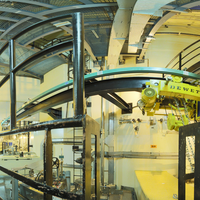

In [22]:
#(960, 230)
x = 1000
y = 2000
h = 10000
w = 10000

img_path = '/dds/work/workspace/data_ja/CAT_1_9024.jpg.ppm'
result = read_from_memory(img_path,x,y,w,h)
show_thumbnail(result)
    
